## 2 Layer MLP for Dark Knoweldge Experiments w/AlignMNIST

75 epochs of RMSProp

Eval extra data first, on same size network

In [1]:
import tensorflow as tf
import numpy as np

In [2]:
%run augmentmnist.py

In [3]:
num_epochs = 75
batch_size = 125

learning_rate = 0.001

In [4]:
# Network Parameters
n_hidden_1 = 800 # 1st layer num features
n_hidden_2 = 800 # 2nd layer num features
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)

std_0  = np.sqrt(6.0/(n_input+n_hidden_1))
std_h1 = np.sqrt(6.0/(n_hidden_1+n_hidden_2))
std_h2 = np.sqrt(6.0/(n_hidden_2+n_classes))

logfile = "2-layer-dlk-alignmnist"

In [5]:
# tf Graph input
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])

xt = tf.placeholder("float", [None, n_input])
yt = tf.placeholder("float", [None, n_classes])

In [6]:
def multilayer_perceptron(_X, _weights, _biases):
    layer_1 = tf.nn.relu(tf.add(tf.matmul(_X, _weights['h1']), _biases['b1'])) 
    layer_2 = tf.nn.relu(tf.add(tf.matmul(layer_1, _weights['h2']), _biases['b2'])) 
    return tf.matmul(layer_2, weights['out']) + biases['out']

In [7]:
# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1], stddev=std_0)),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2], stddev=std_h1)),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes], stddev=std_h2))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1], stddev=0.1)),
    'b2': tf.Variable(tf.random_normal([n_hidden_2], stddev=0.01)),
    'out': tf.Variable(tf.random_normal([n_classes], stddev=0.001))
}

In [8]:
mlp = multilayer_perceptron(x, weights, biases )
mlp_test = multilayer_perceptron(xt, weights, biases )

In [9]:
cost =  tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(mlp, y)) 
gs = tf.get_variable("global_step",[],trainable=False,initializer=tf.constant_initializer(0))
lr = tf.constant(learning_rate) 

In [10]:
train_op = tf.contrib.layers.optimize_loss(cost, global_step=gs, learning_rate=lr,optimizer="RMSProp")

In [11]:
#with tf.name_scope("training accuracy"):
pred = tf.equal(tf.argmax(mlp, 1), tf.argmax(y, 1)) # Count correct predictions
train_acc_op = tf.reduce_mean(tf.cast(pred, "float"))  # Cast boolean to float to average
tf.scalar_summary("training accuracy", train_acc_op)

<tf.Tensor 'ScalarSummary_2:0' shape=() dtype=string>

In [12]:
test_pred = tf.equal(tf.argmax(mlp_test, 1), tf.argmax(yt, 1)) # Count correct predictions
test_acc_op = tf.reduce_mean(tf.cast(test_pred, "float"))  # Cast boolean to float to average
tf.scalar_summary("test 0 accuracy", test_acc_op)

<tf.Tensor 'ScalarSummary_3:0' shape=() dtype=string>

In [13]:
!rm -rf ./logs/{logfile}
!ls logs

2-layer-mlp-alignmnist 5-layer-mlp-alignmnist
2-layer-mlp-infimnist  5-layer-mlp-infimnist


### Original MNIST Data

In [14]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets(".", one_hot=True)
trX_0, trY_0 = mnist.train.images, mnist.train.labels
teX_0, teY_0 = mnist.test.images, mnist.test.labels

Extracting ./train-images-idx3-ubyte.gz
Extracting ./train-labels-idx1-ubyte.gz
Extracting ./t10k-images-idx3-ubyte.gz
Extracting ./t10k-labels-idx1-ubyte.gz


In [15]:
alignmnist = AlignMNIST()

In [16]:
test_accuracies = []
train_accuracies = []
with tf.Session() as sess:
    # create a log writer. run 'tensorboard --logdir=./logs/{logfile}'
    writer = tf.train.SummaryWriter("./logs/{0}".format(logfile), sess.graph) # for 0.8
    merged = tf.merge_all_summaries()
 
    tf.initialize_all_variables().run()

    for epoch in range(num_epochs):
        trX, trY = alignmnist.next_epoch()
      
        for start, end in zip(range(0, len(trX), batch_size), range(batch_size, len(trX), batch_size)):
            sess.run(train_op, feed_dict={x: trX[start:end], y: trY[start:end]})
                 
        summary, trn_acc, tst_acc = sess.run([merged, train_acc_op, test_acc_op], feed_dict={x: trX, y: trY, xt: teX_0, yt: teY_0})
        writer.add_summary(summary, epoch)  
        
        print(epoch, trn_acc, tst_acc)
        train_accuracies.append(trn_acc)
        test_accuracies.append(tst_acc)

        writer.flush()
        

(0, 0.97108334, 0.96319997)
(1, 0.96214998, 0.97640002)
(2, 0.97236669, 0.98009998)
(3, 0.97483331, 0.9831)
(4, 0.97855002, 0.98299998)
(5, 0.98044997, 0.98479998)
(6, 0.98294997, 0.98629999)
(7, 0.98183334, 0.98699999)
(8, 0.97925001, 0.98409998)
(9, 0.98268336, 0.98629999)
(10, 0.98040003, 0.98500001)
(11, 0.98363334, 0.98549998)
(12, 0.98479998, 0.98699999)
(13, 0.98316669, 0.98619998)
(14, 0.97815001, 0.9817)
(15, 0.98456669, 0.98799998)
(16, 0.98154998, 0.9842)
(17, 0.97898334, 0.98449999)
(18, 0.98654997, 0.98940003)
(19, 0.98245001, 0.98439997)
(20, 0.98091668, 0.98460001)
(21, 0.98548335, 0.98860002)
(22, 0.98708332, 0.98769999)
(23, 0.98656666, 0.9892)
(24, 0.98521668, 0.98519999)
(25, 0.98616666, 0.98860002)
(26, 0.97931665, 0.98390001)
(27, 0.98733336, 0.9892)
(28, 0.98273331, 0.98750001)
(29, 0.97896665, 0.98439997)
(30, 0.98436666, 0.98720002)
(31, 0.98438334, 0.98809999)
(32, 0.98693335, 0.98940003)
(33, 0.98796666, 0.98940003)
(34, 0.98711669, 0.98930001)
(35, 0.98346668

In [17]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

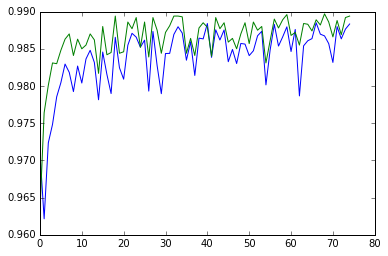

In [18]:
plt.plot(train_accuracies)
plt.plot(test_accuracies)

In [19]:
np.max(test_accuracies)

0.98970002

Number test errors is

In [20]:
10000*(1.0-np.max(test_accuracies))

102.99980640411377